# Investigating Chemical Basis of Essential Nodes

In [107]:
from cobra import Model, Reaction, Metabolite
import cobra.test
from cobra.flux_analysis import (single_gene_deletion, single_reaction_deletion)
import cobra
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import sklearn.metrics as skl_metrics
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import umap
from tqdm import tqdm
import cirpy
from e3fp.pipeline import fprints_from_smiles
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
import hdbscan
from rdkit.Chem import AllChem
import random
from scipy.stats import norm, t

# Generating Background Chemical Space from ChEMl database

In [ ]:
# Reading in all Molecular Structure from ChEBI
suppl = Chem.SDMolSupplier('ChEBI_complete.sdf')
fps_background = []
for mol in suppl:
    if mol is not None:
        fps_background.append(AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024))
fp_arr_bg = []
# Converting C++ vectors to numpy arrays
for fp in fps_background:
    on_bits = list(fp.GetOnBits())
    vec = np.zeros((1024,))
    vec[on_bits] = 1
    fp_arr_bg.append(vec)
fp_arr_bg = np.array(fp_arr_bg)

# Defining Molecular Analysis Function

In [4]:
def run_molecular_analysis(model_xml, sheet_num):
    print(f'Running Analysis for: {model_xml} --> {sheet_num}')
    ## reading in model
    model = cobra.io.read_sbml_model(model_xml)
    ## finding all reactions in model
    reaction_list = []
    reaction_dict = {}
    for reaction in model.reactions:
        ind = str(reaction).find(':')
        reaction_list.append(str(reaction)[:ind])
        reaction_dict[str(reaction)[:ind]] = reaction
    set_full_reactions = set()
    set_full_reactions.update(reaction_list)
    ## reading in adjacency matrix
    df = pd.read_excel('metabolic_networks.xlsx', sheet_name=sheet_num)
    adj_arr = df.to_numpy()
    g_nodes = np.char.strip(adj_arr[:, 0].astype('str'))
    adj_mat = adj_arr[:, 1:].astype('int')
    ## finding all reactions included in adjacency matrix
    set_adj_reactions = set()
    set_adj_reactions.update(list(g_nodes))
    solution = model.optimize()
    obj_value = solution.objective_value
    deletion_results = single_reaction_deletion(model)
    deletion_results['ids'] = deletion_results['ids'].apply(lambda x: list(x)[0])
    # 0.05*obj_function threshold
    essential_rxns = deletion_results[deletion_results['growth'] < (0.05 * obj_value)]['ids'].values
    diff_rxn = set_full_reactions - set_adj_reactions
    model.remove_reactions(list(diff_rxn))
    # finding all metabolites in the adj matrix
    all_mets = set()
    for reaction in model.reactions:
        if reaction.id in set_adj_reactions:
            reaction_mets = [met.id for met in list(reaction.metabolites.keys())]
            all_mets.update(reaction_mets)
    # defining metabolite queries
    metabolite_query = []
    for metabolite in model.metabolites:
        if metabolite.id in all_mets:
            metabolite_query.append((metabolite.name, metabolite.id, metabolite.formula))
    # converting names to SMILES
    smiles_dict = {}
    no_res = []
    for name, met_id, formula in tqdm(metabolite_query):
        name = name.strip()
        name = name.replace('\t', '')
        name = name.replace('  ', ' ')
        name = name.replace('   ', ' ')
        split_name = name.split(' ')
        if split_name[-1] == formula:
            name = ' '.join(split_name[:-1])
        name = name.lower()
        name = name.strip()
        try:
            res = cirpy.resolve(name, 'smiles')
        except:
            res = None
            print(f'URLError encountered for {name}')
        if res is not None:
            smiles_dict[met_id] = res
        else:
            no_res.append(met_id)
    names = []
    mols = []
    # Generating fingerprints
    for name, smile in tqdm(smiles_dict.items()):
        names.append(name)
        mols.append(Chem.MolFromSmiles(smile))
    fps = []
    for mol in mols:
        if mol is not None:
            fps.append(AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024))
        else:
            fps.append(None)
    fp_vecs = []
    fp_names = []
    for name, fp in zip(names, fps):
        if fp is not None:
            on_bits = list(fp.GetOnBits())
            vec = np.zeros((1024,))
            vec[on_bits] = 1
            fp_vecs.append(vec)
            fp_names.append(name)
    fp_arr = np.array(fp_vecs)
    essential_mets = set()
    for reaction in model.reactions:
        if reaction.id in essential_rxns:
            reaction_mets = [met.id for met in list(reaction.metabolites.keys())]
            essential_mets.update(reaction_mets)
    essential_fp = []
    for met_id in fp_names:
        if met_id in essential_mets:
            essential_fp.append(True)
        else:
            essential_fp.append(False)
    essential_fp = np.array(essential_fp)
    return [fp_arr, fp_names, essential_fp]

# Running All Molecular Analyses

In [ ]:
ecoli_info = run_molecular_analysis('iJO1366.xml', 0)
bsubtilis_info = run_molecular_analysis('iYO844.xml', 1)
gmetallireducens_info = run_molecular_analysis('iAF987.xml', 2)
kpneumoniae_info = run_molecular_analysis('iYL1228.xml', 3)
scerevisiae_info = run_molecular_analysis('iMM904.xml', 4)

# Combining Chemcical Information from all Microorganisms and ChEBI

In [9]:
info_list = [ecoli_info, bsubtilis_info, gmetallireducens_info, kpneumoniae_info, scerevisiae_info]
all_names = np.hstack([x[1] for x in info_list])
all_essential = np.hstack([x[2] for x in info_list])
all_fp_arr = np.vstack([x[0] for x in info_list])
sample = np.array(random.sample(set(np.arange(fp_arr_bg.shape[0])), k=20000))
sampled_fp_bg = fp_arr_bg[sample]
full_fp_arr = np.vstack([sampled_fp_bg, all_fp_arr])

In [10]:
all_dict = {}
for name, essential, fp_arr in zip(list(all_names), list(all_essential), list(all_fp_arr)):
    if name in all_dict.keys():
        instance = all_dict[name]
        instance.append((fp_arr, essential))
        all_dict[name] = instance
    else:
        all_dict[name] = [(fp_arr, essential)]

# UMAP embedding for ChEBI and Co-embedding metabolites from microorganisms
reducer = umap.UMAP(n_neighbors=20, metric='jaccard')
embedding = reducer.fit_transform(sampled_fp_bg)
met_embedding = reducer.transform(all_fp_arr)

# Plotting UMAP output

<Figure size 1080x1080 with 0 Axes>

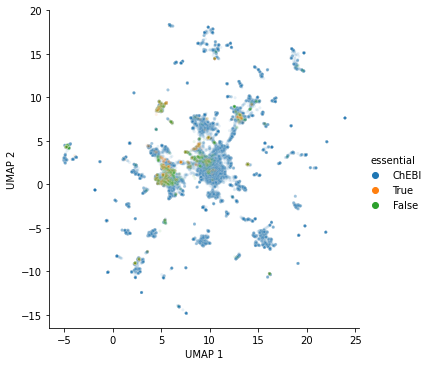

In [12]:
umap_df = pd.DataFrame({'UMAP 1': met_embedding[:, 0], 
                        'UMAP 2': met_embedding[:, 1], 
                        'essential': all_essential, 
                        'rxn_id': all_names})
umap_bg_df = pd.DataFrame({'UMAP 1': embedding[:, 0],
                           'UMAP 2': embedding[:, 1], 
                           'essential': ['ChEBI']*len(embedding), 
                           'rxn_id': ['ChEBI']*len(embedding)})
full_umap_df = pd.concat([umap_bg_df, umap_df], axis=0)
plt.figure(figsize=(15,15))
sns.relplot(data=full_umap_df, x='UMAP 1', y='UMAP 2', hue='essential', marker='.', alpha=0.1)
plt.show()

# Clustering ChEBI UMAP Embedding

In [22]:
# Clustering
clusterer = hdbscan.HDBSCAN(min_samples=20, cluster_selection_epsilon=0.3)
clusterer.fit(full_umap_df.loc[:, ['UMAP 1', 'UMAP 2']].values)
labels = clusterer.labels_.astype('float')
# Creating seaborn pallette for plotting clusters
palette = []
r = lambda: random.randint(20,255)
for _ in range(int(np.amax(labels)+2)):
    color = '#%02X%02X%02X' % (r(),r(),r())
    if color not in palette:
        palette.append(color)
palette[0] = '#808080'

81.0

# Plotting the Clustered UMAP Embedding

<Figure size 1080x1080 with 0 Axes>

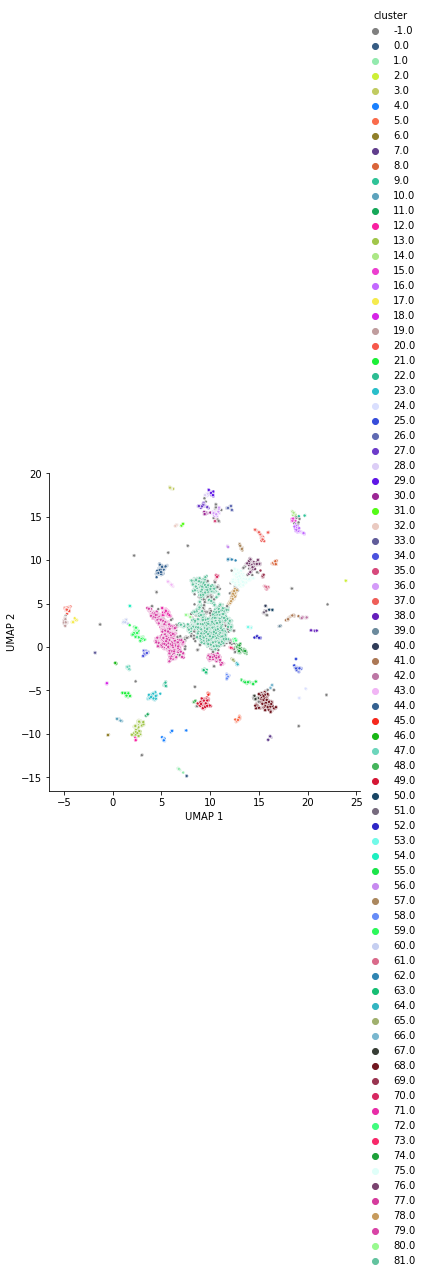

In [24]:
full_umap_df['cluster'] = labels
plt.figure(figsize=(15,15))
sns.relplot(data=full_umap_df, x='UMAP 1', y='UMAP 2', hue='cluster', marker='.', palette=sns.color_palette(palette))
plt.show()

In [53]:
# finding 
met_cluster_df = full_umap_df[full_umap_df['essential'].isin([True])]
num_essential = met_cluster_df.groupby('essential').count().values[0, 0]
enrich_dict = dict(met_cluster_df.groupby('cluster').count()['essential'])

# Enrichment Analysis

In [72]:
## Bootstrapping
bs_num = 50000
cluster_dict = {x: {c: 0 for c in np.arange(-1, np.amax(labels)+1)} for x in range(bs_num)}
for sample_num in range(bs_num):
    samples = random.sample(set(np.arange(len(sampled_fp_bg))), k=num_essential)
    null_labels = labels[samples]
    for label in null_labels:
        cluster_dict[sample_num][label] += 1



In [115]:
## Calculating Z-scores and p-values (discrete and continuous)
zscore_dict = {}
pval_dict = {}
pvalc_dict = {}
for clust in enrich_dict.keys():
    null_dist = []
    for sample_key in cluster_dict.keys():
        null_val = cluster_dict[sample_key][clust]
        null_dist.append(null_val)
    null_dist = np.array(null_dist)
    zscore = (null_dist.mean() - enrich_dict[clust])/null_dist.std()
    pval = np.count_nonzero(abs(null_dist-null_dist.mean()) > abs(enrich_dict[clust]-null_dist.mean()))/len(null_dist)
    zscore_dict[clust] = zscore
    pval_dict[clust] = pval*len(np.unique(labels))
    pvalc_dict[clust] = t.cdf(-np.abs(zscore), df=num_essential)*len(np.unique(labels))

# Creating df for plotting
zscore_sig = dict([item for item in zscore_dict.items() if item[1]> 0])
pval_sig = dict([item for item in pvalc_dict.items() if item[1] < 0.05])
sig_clusts = list(set(zscore_sig) & set(pval_sig))
sig_clusts.remove(-1)
zscore_sig = dict([item for item in zscore_dict.items() if item[0] in sig_clusts])
pval_sig = dict([item for item in pvalc_dict.items() if item[0] in sig_clusts])
pval_sig_df = pd.DataFrame({'p-value': list(pval_sig.values()), 'Z-score': np.array(list(zscore_sig.values())).astype('float32'), 'Chemical Cluster': np.array(list(zscore_sig.keys())).astype('int')})
pval_sig_df

# Plotting Significantly Enriched Chemical Clusters

<Figure size 1080x1080 with 0 Axes>

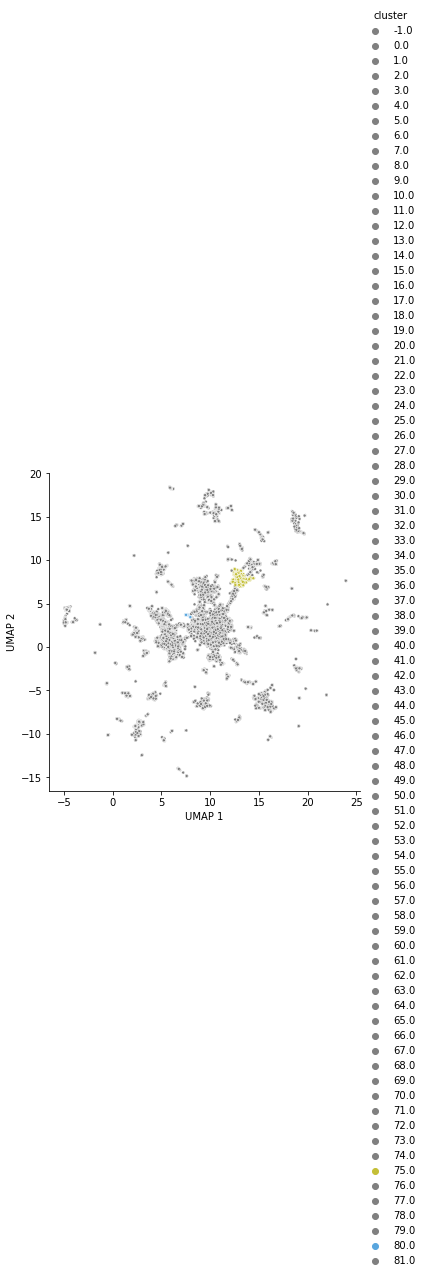

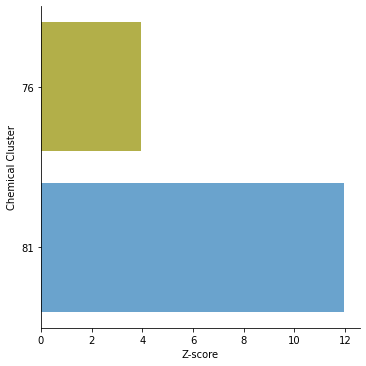

In [162]:
palette = []
bar_pal = []
r = lambda: random.randint(20,255)
for clust in range(int(np.amax(labels)+2)):
    color = '#%02X%02X%02X' % (r(),r(),r())
    if color not in palette and clust in sig_clusts:
        palette.append(color)
        bar_pal.append(color)
    else:
        palette.append('#808080')

full_umap_df['cluster'] = labels
plt.figure(figsize=(15,15))
sns.relplot(data=full_umap_df, x='UMAP 1', y='UMAP 2', hue='cluster', marker='.', palette=sns.color_palette(palette))
plt.show()
sns.catplot(data=pval_sig_df, y='Chemical Cluster', x='Z-score', kind='bar', orient='h', palette=sns.color_palette(bar_pal))
plt.show()